In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# ----- Random walk definition (19 nonterminal states, terminals 0 and 20) -----
N_NONTERMINAL = 19
TERMINAL_LEFT = 0
TERMINAL_RIGHT = N_NONTERMINAL + 1
START_STATE = math.ceil(N_NONTERMINAL/2)
GAMMA = 1.0

# Rewards: entering left terminal gives -1, entering right terminal gives +1, else 0
R = np.zeros(N_NONTERMINAL + 2, dtype=np.float32)
R[TERMINAL_LEFT] = 0.0
R[TERMINAL_RIGHT] = +1.0

In [2]:
def true_values():
    """
    For unbiased random walk with terminal returns -1/+1:
    P(reach right terminal | state i) = i / 20, for i=0..20
    v(i) = 2*P(right|i) - 1 = 2*(i/20) - 1 for i=1..19
    We'll keep terminal entries at 0 in the table (not used for RMS).
    """
    v = np.zeros(N_NONTERMINAL + 2, dtype=np.float32)
    for i in range(1, TERMINAL_RIGHT):
        v[i] = 2.0 * (i / float(TERMINAL_RIGHT)) - 1.0
    return v


V_TRUE = true_values()

In [3]:
def rms_error(V: np.ndarray) -> float:
    err = V[1:TERMINAL_RIGHT] - V_TRUE[1:TERMINAL_RIGHT]
    return float(np.sqrt(np.mean(err * err)))

In [4]:
# ----- 1) Generate episode ONCE -----
def generate_episode(rng: np.random.Generator):
    """
    Generate one episode under the random policy (left/right with prob 0.5).
    Returns:
        states: list [S0, S1, ..., ST]  (ST terminal)
        rewards: list [R1, R2, ..., RT] (len == T)
    """
    s = START_STATE
    states = [s]
    rewards = []

    while s not in (TERMINAL_LEFT, TERMINAL_RIGHT):
        action = int(rng.integers(0, 2))  # 0=left, 1=right
        s_next = s + (1 if action == 1 else -1)
        r_next = float(R[s_next])

        rewards.append(r_next)   # this is R_{t+1}
        states.append(s_next)    # this is S_{t+1}
        s = s_next

    return states, rewards

In [5]:
# ----- 2) Learn from a GIVEN episode -----
def n_step_td_from_episode(V: np.ndarray, states, rewards, n: int, alpha: float, gamma: float = 1.0):
    """
    Online n-step TD prediction update over a fixed episode.
    Uses circular buffers of length n+1 for S_t and R_t.
    """
    T = len(rewards)  # number of transitions until terminal

    Sbuf = np.zeros(n + 1, dtype=np.int32)
    Rbuf = np.zeros(n + 1, dtype=np.float32)

    # Store S0
    Sbuf[0] = states[0]

    t = 0
    while True:
        if t < T:
            # observe and store R_{t+1}, S_{t+1}
            Rbuf[(t + 1) % (n + 1)] = rewards[t]
            Sbuf[(t + 1) % (n + 1)] = states[t + 1]

        tau = t - n + 1
        if tau >= 0:
            # G = sum_{i=tau+1}^{min(tau+n, T)} gamma^{i-tau-1} R_i
            G = 0.0
            end = min(tau + n, T)
            for i in range(tau + 1, end + 1):
                G += (gamma ** (i - tau - 1)) * Rbuf[i % (n + 1)]

            # bootstrap if tau+n < T
            if tau + n < T:
                G += (gamma ** n) * V[Sbuf[(tau + n) % (n + 1)]]

            s_tau = int(Sbuf[tau % (n + 1)])
            if s_tau not in (TERMINAL_LEFT, TERMINAL_RIGHT):
                V[s_tau] += alpha * (G - V[s_tau])

        if tau == T - 1:
            break
        t += 1

In [6]:
# ----- Experiment: generate walks once per repetition, replay for all (n, alpha) -----
def run_experiment(n_values, alpha_values, num_episodes=10, num_reps=100, seed=0):
    results = {n: np.zeros(len(alpha_values), dtype=np.float64) for n in n_values}

    rng_master = np.random.default_rng(seed)

    for rep in range(num_reps):
        # Generate the SAME set of episodes for this repetition
        rep_seed = int(rng_master.integers(0, 2**32 - 1))
        rng_rep = np.random.default_rng(rep_seed)
        episodes = [generate_episode(rng_rep) for _ in range(num_episodes)]

        # Replay those identical episodes for every (n, alpha)
        for n in n_values:
            for ai, alpha in enumerate(alpha_values):
                V = np.zeros(N_NONTERMINAL + 2, dtype=np.float32)

                ep_errs = []
                for (states, rewards) in episodes:
                    n_step_td_from_episode(V, states, rewards, n=n, alpha=float(alpha), gamma=GAMMA)
                    ep_errs.append(rms_error(V))  # RMS after each episode

                results[n][ai] += float(np.mean(ep_errs))

    for n in n_values:
        results[n] /= num_reps

    return results

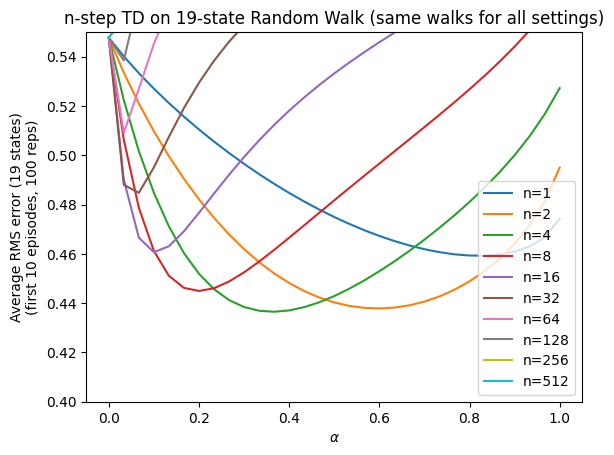

In [7]:
n_values = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
alpha_values = np.linspace(0.0, 1.0, 31)  # 0.00, 0.05, ..., 1.00

results = run_experiment(n_values, alpha_values, num_episodes=10, num_reps=100, seed=1)

plt.figure()
for n in n_values:
    plt.plot(alpha_values, results[n], label=f"n={n}")

plt.xlabel(r"$\alpha$")
plt.ylabel(f"Average RMS error ({N_NONTERMINAL} states)\n(first 10 episodes, 100 reps)")
plt.title(f"n-step TD on {N_NONTERMINAL}-state Random Walk (same walks for all settings)")
plt.legend()
plt.ylim(0.4, 0.55)
plt.show()